# 16 Land cover statistics

## About the data

In this lesson we will use two datasets.

The first one is [GAP/LANDFIRE National Terrestrial Ecosystems data for 2011 @davidson_gaplandfire_2016](https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5), from the [US Geological Survey (USGS)](https://www.usgs.gov). This is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. We will access this data through the [Microsoft Planetary Computer (MPC) data catalog](https://planetarycomputer.microsoft.com/dataset/gap). The class names and corresponding codes have been saved to a separete CSV to simplify access in this lesson. Further information on how to access the classes directly from the data are available in the [MPC catalog](https://planetarycomputer.microsoft.com/dataset/gap#Example-Notebook).


The second dataset is a shapefile with the perimeters for 2017 California fires. This data was extracted from the CALFIRE's [Historical Wildland Fire Perimeters](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/about).

## Import auxiliary geometries

Let's start by importing the necessary libraries:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

Then import and select the Thomas Fire within the fire perimeters data:

<Axes: >

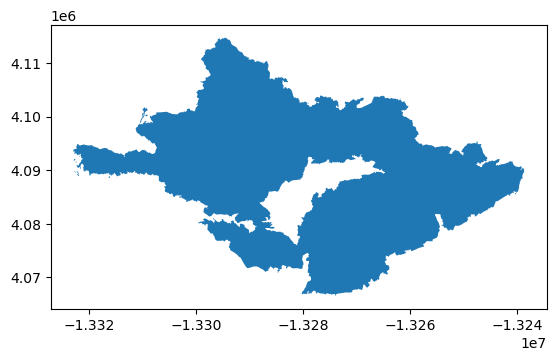

In [2]:
root = os.path.join('/','courses','EDS220','data')
fire_perimeters = gpd.read_file(os.path.join(root,
                  'California_Fire_Perimeters_2017',
                  'California_Fire_Perimeters_2017.shp'
                 ))
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']

# Examine fire perimeter data
thomas_fire.crs
thomas_fire.plot()

And import the CA state perimeter:

<Axes: >

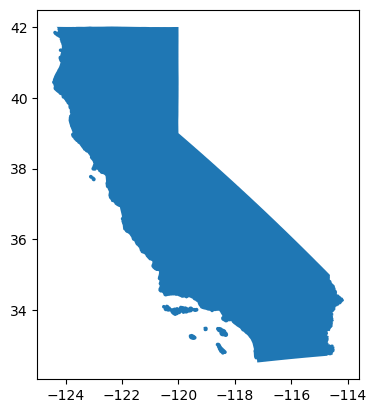

In [3]:
ca = gpd.read_file(os.path.join(root,
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))
ca.plot()

## Catalog search

Our goal is to retrieve the National Terrestrial Ecosystems data over the fire perimeter. In the [last lesson](/book/chapters/lesson-16-STAC.qmd) we used GeoJSON-type dictionary to do the catalog search. Here we will use a list `[xmin, ymin, xmax, ymax]` with the coordinate values defining the four corners of the region we want to search data over. Just as the GeoJSON, these coordinates have to be in the EPSG:4326 CRS. 

Our bounding box will come from the Thomas Fire perimeter. Notice we use method chaining to reproject and extract the bounds.

In [6]:
# Create bounding box for search
thomas_fire_bbox = list(thomas_fire.to_crs('epsg:4326').total_bounds)
thomas_fire_bbox

[-119.68162520650904,
 34.279899796001956,
 -118.92518097019486,
 34.63745683414112]

Next, we connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for the National Terrestrial Ecosystems data is `gap`:

In [7]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [8]:
# Search MPC catalog 
search = catalog.search(collections=['gap'],
                       bbox=thomas_fire_bbox)
search

In [10]:
# Retrieve search items 
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 1 Items


There is a single item in the search, so let’s go ahead and select it and view its pre-rendered image:

In [11]:
# Select unique item in search 
item = items[0]

# Display pre-rendered image 
Image(url=item.assets['rendered_preview'].href, width=600)

At this point, we can also import the CSV file with the class labels:

In [13]:
labels = pd.read_csv(os.path.join(root,
                                  'GAP_National_Terrestrial_Ecosystems.csv')
                                  )
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


## Explore raster
Next, we can go ahead an open the raster:



In [14]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

Notice that band is a dimension of length 1. We can go ahead and “squeeze” the raster to simplify it:

In [15]:
# Remove length 1 dimension 
lulc = lulc.squeeze().drop_vars('band')
print('Sizes of dimensions: ', dict(lulc.sizes))

Sizes of dimensions:  {'y': 10000, 'x': 10000}


In [16]:
lulc.rio.bounds()

(-2361135.0, 1462215.0, -2061135.0, 1762215.0)

This is just a list of numbers, we need to construct the geometries 

In [18]:
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                             crs = lulc.rio.crs)
lulc_bbox

,geometry
0,"POLYGON ((-2061135.000 1462215.000, -2061135.0..."


In [20]:
ca = gpd.read_file(os.path.join(root,
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))

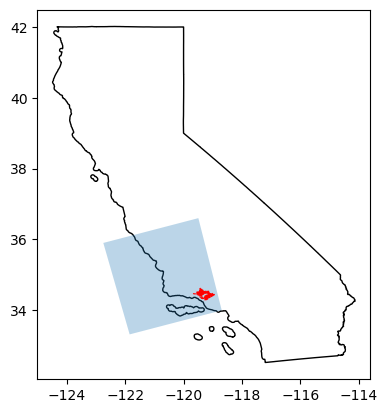

In [21]:
# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()
ca.plot(ax=ax, color='white', edgecolor ='black')

# Reproject lulc_bbox and fire perimeter to match CA crs
lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)  
thomas_fire.to_crs(ca.crs).plot(ax=ax, color='red')

plt.show()

We can see the raster covers a big area relative to the fire perimeter. Since we want to calculate the land coverage statistics within the fire perimeter, we will have to clip the raster to this area.

## Clip raster to geometry

In our first lesson about rasters we saw how to clip a raster to a rectangular region. In our case, we want to clip the raster exactly to the fire perimeter. Clipping can be a costly operation for such a big raster relative to a detailed geometry. So we will perform the clipping in two steps:

1. Clip the raster using the fire perimeter bounding box using `rio.clip_box()` and then
2. Clip the simplified raster to the fire perimeter using `rio.clip()`.

In [22]:
# Match CRSs and verify update 
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

In [23]:
# Clip large raster to detailed geometry in two steps 
lulc_step1 = lulc.rio.clip_box(*thomas_fire_match.total_bounds)

In [24]:
lulc_step2 = lulc_step1.rio.clip(thomas_fire_match.geometry)

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


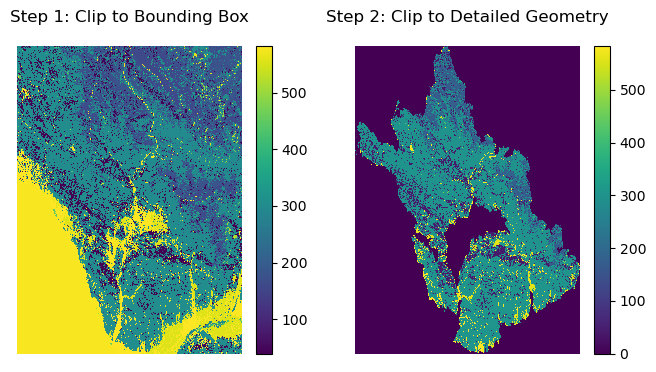

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first clipped raster
lulc_step1.plot(ax=ax[0], cmap="viridis")
ax[0].set_title("Step 1: Clip to Bounding Box")
ax[0].axis("off")

# Plot the second clipped raster
lulc_step2.plot(ax=ax[1], cmap="viridis")
ax[1].set_title("Step 2: Clip to Detailed Geometry")
ax[1].axis("off")

plt.show()

## Raster no-data values

Notice a warning appeared when we clipped the raster. After some investigation, we will find that this `RuntimeWarning` occurs because the `rio.clip()` function tries to replace values outside the fire perimeter geometry with `np.nan`. However, as we previously saw, our raster’s data type is `uint16` (16 bits unsigned integer). The cast issue appears since `np.nan` is a float (decimal number) and it cannot be casted as a `uint16`. 

To make sure the clipping operator fills in any pixels with the adequate no-data value, let’s manually set it:



In [27]:
print('Original no-data value: ', lulc.rio.nodata)

Original no-data value:  None


In [28]:
# Update raster's no-data value 
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

Updated no-data value:  0


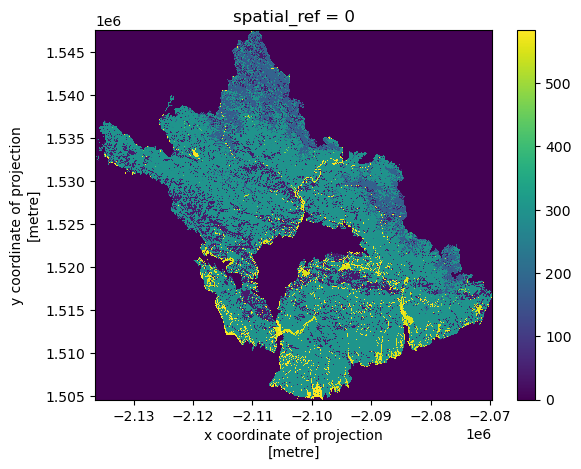

In [29]:
# Combine step 1 and step 2 
lulc_clip = (lulc.rio.clip_box(*thomas_fire_match.total_bounds)
                 .rio.clip(thomas_fire_match.geometry)
                 )
# Examine results 
lulc_clip.plot()

## Exercise 

1. Use the numpy function np.unique() to get the number of pixels per class in lulc_clip. HINT: check the np.unique() documentation to see what the return_counts parameter does and read the last example.

In [35]:
np.unique(lulc_clip, return_counts=True)

(array([  0,  39,  40,  41,  42,  43,  45,  55, 159, 162, 165, 183, 277,
        278, 282, 296, 297, 300, 302, 303, 304, 305, 359, 360, 383, 385,
        432, 470, 472, 485, 489, 516, 539, 540, 547, 552, 553, 556, 557,
        558, 567, 568, 578, 579, 581, 582, 583, 584], dtype=uint16),
 array([1927850,    6856,     361,  133707,    3639,   23148,    2907,
           4974,    3727,   60203,    5102,   75924,     378,   11098,
             29,      98,   64073,   69702,  183963,  454498,   88503,
            799,     750,     684,      28,      90,     865,     262,
           1329,      54,      44,      27,     298,      24,      15,
             43,       7,   19000,    2181,     485,      13,      20,
             10,    1856,   40658,    3782,     830,      58]))

2. Create a data frame pix_counts with two columns: column one must be the code numbers for the pixels in lulc_clip and column two must be the number of pixels corresponding to each code. HINT: check our class notes on pandas.DataFrames